## Recognition of texts in editions of the Cyrillic Church Slavonic font

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import *
import tensorflow as tf
from tensorflow import keras
from alphabet import CHURCH_SLAVONIC_LETTERS, CHURCH_SLAVONIC_DIACRITICS, CHURCH_SLAVONIC_VOWELS, LETTERS_WITH_TITLE
from keras import backend as K
K.set_image_data_format('channels_first')

### Text line segmentation

Detection of peaks in the horizontal projection of the image. These peaks give us an idea of where the segmentation between two lines can be done.

In [2]:
def get_peak_regions(hpp):
    divider=1.8
    threshold = (np.max(hpp)-np.min(hpp))/divider
    threshold_line = [threshold for i in range(len(hpp))]
    plt.figure(1)
    plt.plot(hpp)
    plt.plot(threshold_line)
    plt.show()
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

def get_walking_regions_between_lines(peaks):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks):
        cluster.append(value)
        if index < len(peaks)-1 and peaks[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []
        if index == len(peaks)-1:
            hpp_clusters.append(cluster)
            cluster = []
    return hpp_clusters

A* Path planning algorithm along the segmentation region.

In [3]:
def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []
    heappush(oheap, (fscore[start], start))
    while oheap:
        current = heappop(oheap)[1]
        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data
        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 255:
                        continue
                else:
                    continue
            else:
                continue  
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue    
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))     
    return []

Converting to Grayscale Using the Otsu's Method.

In [4]:
def thresholding(image, inv=True):
    if inv:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    return thresh

Definition of regions where upper line text is connected to the lower line.

In [5]:
def existence_of_path(window_image):
    if 0 in np.sum(window_image, axis=1):
        return True
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True
        if existence_of_path(nmap[:, start:end]) == False:
            road_blocks.append(col)
        if needtobreak == True:
            break
    return road_blocks

def merge_road_blocks(road_blocks):
    blocks_cluster_groups = []
    blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            blocks_cluster_groups.append([blocks_cluster[0], blocks_cluster[len(blocks_cluster)-1]])
            blocks_cluster = []
        if index == size-1 and len(blocks_cluster) > 0:
            blocks_cluster_groups.append([blocks_cluster[0], blocks_cluster[len(blocks_cluster)-1]])
            blocks_cluster = []
    return blocks_cluster_groups

Extracting a line from an image

In [6]:
def cut_line_from_image(image, lower_line, upper_line):
    lower_boundary = np.min(lower_line[:, 0])
    upper_boundary = np.max(upper_line[:, 0])
    image_copy = np.copy(image)
    r, c = image_copy.shape
    for index in range(c-1):
        image_copy[0:lower_line[index, 0], index] = 255
        image_copy[upper_line[index, 0]:r, index] = 255
    return image_copy[lower_boundary:upper_boundary, :]

def split_indexes_into_groups(peaks):
    grouped_peaks = [[peaks[0]]]
    for i in range(1, len(peaks)):
        if peaks[i] == peaks[i - 1] + 1:
            grouped_peaks[-1].append(peaks[i])
        else:
            grouped_peaks.append([peaks[i]])
    return grouped_peaks

This function detects short lines that were skipped when peaks were detected in the horizontal projection. Since the width of the lines in old printed books is the same, it's possible to find missing short lines that are the same width as those found earlier.

In [7]:
def add_short_lines(peaks_index, hpp):
    hpp_peaks = split_indexes_into_groups(peaks_index)
    avg_len = sum([len(x) for x in hpp_peaks])/len(hpp_peaks)
    for i in range(len(hpp_peaks)):
        if len(hpp_peaks[i]) <= avg_len/2:
            left_hpp = hpp_peaks[i-1][-1] if i != 0 else -1000
            right_hpp = hpp_peaks[i+1][0] if i != len(hpp_peaks)-1 else 1000
            if (hpp_peaks[i][0] - left_hpp) < (right_hpp - hpp_peaks[i][-1]):
                for j in range(left_hpp+1, hpp_peaks[i][0]):
                    peaks_index = np.append(j, peaks_index)
            else:
                 for j in range(hpp_peaks[i][-1]+1, right_hpp):
                    peaks_index = np.append(j, peaks_index)
    peaks_index.sort()               
    
    divider=1.8
    threshold = (np.max(hpp)-np.min(hpp))/divider
    inv_peaks_index = []
    for i in range(len(hpp)):
        if i not in peaks_index:
            inv_peaks_index.append(i)
    inv_hpp_peaks = split_indexes_into_groups(inv_peaks_index)
    length = [len(x) for x in inv_hpp_peaks]
    max_len = max(length)
    min_len = max(length) if min(length) <= max(length)/2 else min(length)
    
    min_threshold = np.min(hpp) + 1000
    h = (threshold - min_threshold)/10
    new_peaks = []
    while min_threshold < threshold:
        peaks = []
        for i, hppv in enumerate(hpp):
            if hppv > min_threshold:
                peaks.append(i)
        len_peaks = split_indexes_into_groups(peaks)
        peaks = []
        for lenp in len_peaks:
            if min_len <= len(lenp) <= max_len:
                for l in lenp:
                    peaks.append(l)
        peaks = [x for x in peaks if x not in inv_peaks_index]
        if len(peaks):
            len_peaks = split_indexes_into_groups(peaks)
            for lenp in len_peaks:
                if min_len <= len(lenp) <= max_len:
                    for l in lenp:
                        if l not in new_peaks:
                            new_peaks.append(l)
        min_threshold += h
    for npeak in new_peaks:
        peaks_index = peaks_index[peaks_index != npeak]
    return peaks_index

Line segmentation function.

In [8]:
def line_segmentation(path):
    img = cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_img = np.sqrt(Gx * Gx + Gy * Gy)
    hpp = np.sum(sobel_img, axis=1)
    peaks = get_peak_regions(hpp)
    peaks_index = np.array(peaks)[:,0].astype(int)
    peaks_index = add_short_lines(peaks_index, hpp)

    segmented_img = np.copy(img)
    h, w = segmented_img.shape
    for i in range(h):
        if i in peaks_index:
            segmented_img[i, :] = 0
    hpp_clusters = get_walking_regions_between_lines(peaks_index)
    binary_image = thresholding(img)
    
    for cluster_of_interest in hpp_clusters:
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        road_blocks = get_road_block_regions(nmap)
        road_blocks_cluster_groups = merge_road_blocks(road_blocks)
        val = 10
        for index, road_blocks in enumerate(road_blocks_cluster_groups):
            window_image = nmap[:, road_blocks[0]: road_blocks[1]+val]
            window_image *= 0
            binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:][:, road_blocks[0]: road_blocks[1]+val] = window_image
    
    line_segments = []
    for i, cluster_of_interest in enumerate(hpp_clusters):
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
        if len(path) > 0:
            offset_from_top = cluster_of_interest[0]
            path[:,0] += offset_from_top
            line_segments.append(path)
    
    cluster_of_interest = hpp_clusters[1]
    offset_from_top = cluster_of_interest[0]
    fig, ax = plt.subplots(figsize=(20,10), ncols=2)
    for path in line_segments:
        ax[1].plot((path[:,1]), path[:,0], 'k')
    ax[1].axis("off")
    ax[0].axis("off")
    ax[1].imshow(img, cmap="gray")
    ax[0].imshow(img, cmap="gray")
    
    last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), 
                                               np.arange(img.shape[1]))).astype(int), axis=0)
    line_segments.append(last_bottom_row)   
    
    line_images = []
    line_count = len(line_segments)
    
    for line_index in range(line_count-1):
        line_image = cut_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
        line_images.append(line_image)
        
    sum = 0
    for line_index in range(line_count-1):
        sum += np.min(line_segments[line_index+1][:, 0]) - np.min(line_segments[line_index][:, 0])
    avg = sum / line_count

    for line_index in range(line_count-1):
        line_width = np.min(line_segments[line_index+1][:, 0]) - np.min(line_segments[line_index][:, 0])
        if line_width < avg // 2 and line_index == line_count-2:
            line_images.pop(line_index)
    return line_images

Page title:  images/image.jpg


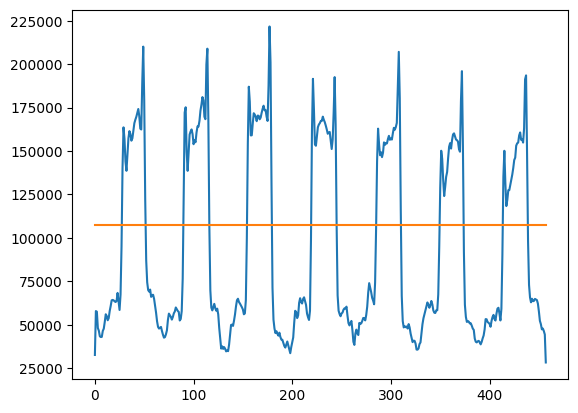

CPU times: total: 5.28 s
Wall time: 8.35 s


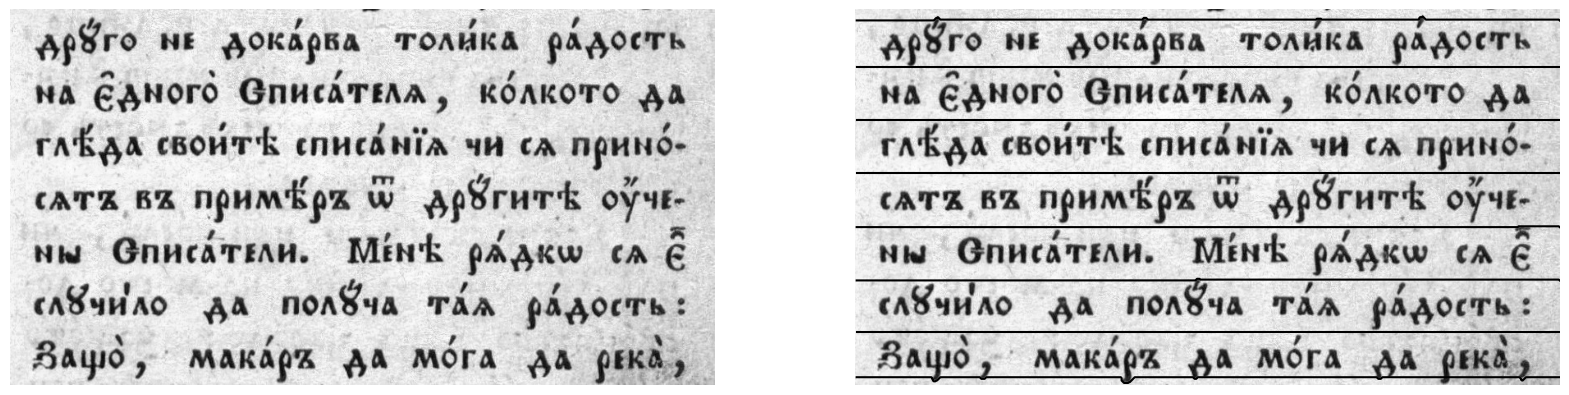

In [9]:
%%time
page = input('Page title: ')
line_images = line_segmentation(page)

### Word segmentation

Removing white space to the left and right of a line.

In [10]:
def cropp_line(line_image):
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    height = line_image.shape[0]
    index = 0       
    while vertical_projection[index] == height:
        index += 1
    if index > 2:
        index -= 2
    line_image = line_image[:, index:]
    
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    
    index = line_image.shape[1] - 1
    while vertical_projection[index] == height:
        index -= 1
    if index < line_image.shape[1] - 1:
        index += 2
    
    line_image = line_image[:, :index]
    return line_image

Binarization and noise removal from a line image. Then finding the vertical projection of the image to find long white blocks because thats what represents spaces.

In [11]:
def word_segmentation(line_image, display_result=False):
    line = cropp_line(line_image)
    dst = cv2.fastNlMeansDenoising(line, None, 12, 7, 21)
    thresh = thresholding(dst)
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1) 
    binary = line > dilated
    vertical_projection = np.sum(binary, axis=0)
    
    height = line.shape[0]
    whitespace_lengths = []
    current_whitespace = 0
    for vp in vertical_projection:
        if vp == height:
            current_whitespace += 1
        elif current_whitespace:
            whitespace_lengths.append(current_whitespace)
            current_whitespace = 0

    if current_whitespace:
        whitespace_lengths.append(current_whitespace)

    avg_white_space_length = np.mean(whitespace_lengths) if whitespace_lengths else 0
    
    divider_indexes = [0]
    current_whitespace = 0
    for index, vp in enumerate(vertical_projection):
        if vp == height:
            current_whitespace += 1
        else:
            if current_whitespace > avg_white_space_length:
                divider_indexes.append(index - current_whitespace // 2)
            current_whitespace = 0

    if display_result:
        line_copy = line.copy()
        mask = np.zeros_like(line_copy, dtype=bool)
        mask[:, divider_indexes] = True
        line_copy[mask] = 0

        plt.figure(figsize=(6,15))
        plt.imshow(line_copy, cmap="gray")
        plt.show()
    
    divider_indexes.append(len(vertical_projection))

    dividers = np.column_stack((divider_indexes[:-1], divider_indexes[1:]))
    
    words = [line[:, window[0]:window[1]] for window in dividers]

    return words

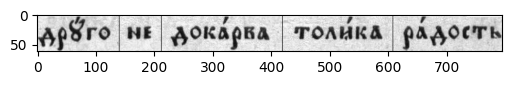

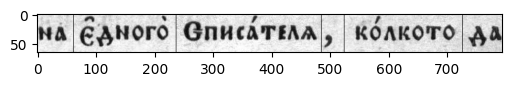

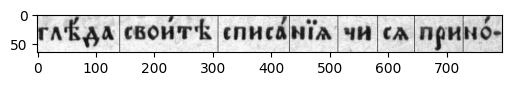

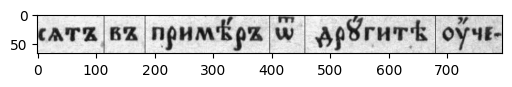

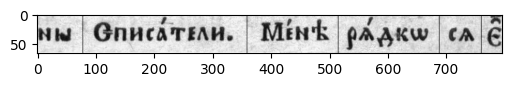

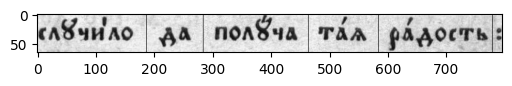

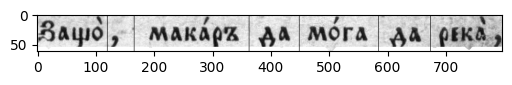

In [12]:
for i in range(len(line_images)):
    words = word_segmentation(line_images[i], True)

### Letter segmentation

In [13]:
def min_sorted_contours(sorted_contours):
    return min(cv2.boundingRect(ctr)[1] for ctr in sorted_contours)

def find_contours(letter, sort):
    (contours, heirarchy) = cv2.findContours(letter.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[sort])
    return sorted_contours

The function that connects a cut character that has an accent above it

In [14]:
def merge_letters(letters):
    
    def hconcat_resize_min(im_list):
        h_min = min(im.shape[0] for im in im_list)
        im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=cv2.INTER_CUBIC)
                          for im in im_list]
        return cv2.hconcat(im_list_resize)
    
    def is_eligible_for_merge(letter, sorted_contours):
        if len(sorted_contours) < 2:
            return False
        x, y, w, h = cv2.boundingRect(sorted_contours[0])
        y_next = min_sorted_contours(sorted_contours[1:])
        return y_next > y + h and y + h < letter.shape[0] // 2 and x + w == letter.shape[1] and w * h > 10

    unite_letters = []
    i = 0
    while i < len(letters):
        sorted_contours = find_contours(letters[i], 1)

        if is_eligible_for_merge(letters[i], sorted_contours) and i != len(letters) - 1:
            sorted_contours_next = find_contours(letters[i + 1], 1)

            if is_eligible_for_merge(letters[i + 1], sorted_contours_next) and cv2.boundingRect(sorted_contours_next[0])[0] == 0:
                unite_letters.append(hconcat_resize_min([letters[i], letters[i + 1]]))
                i += 2
                continue

        unite_letters.append(letters[i])
        i += 1

    return unite_letters

Segmentation of letters in a word image using ```find contours``` from OpenCV.

In [15]:
def letter_segmentation(word):
    dst = cv2.fastNlMeansDenoising(word, None, 12, 7, 21)
    thresh_img = thresholding(dst)

    kernel = np.ones((2, 1), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)    
    sorted_contours = find_contours(dilated, 0)

    top = thresh_img.shape[0] / 2
    bottom = thresh_img.shape[0] * 2 / 3
    min_area = 10

    letters = []
    for ctr in sorted_contours:
        x, y, w, h = cv2.boundingRect(ctr)
        if y + h > top + 3 and y - 1 < bottom and w * h >= min_area:
            crop_x = max(x - 1, 0)
            letter = thresh_img[:y + h + 1, crop_x:x + w + 1]
            letters.append(letter)
                
    plt.figure(figsize=(4, 1)) 
    for i, letter in enumerate(letters):
        plt.subplot(1, len(letters), i+1)
        plt.imshow(letter, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    
    return merge_letters(letters)

Two or more letters that have been combined into one contour are additionally cut if the image width is 2 times larger than the average letter.

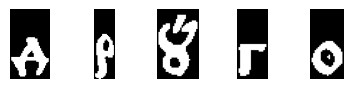

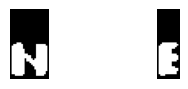

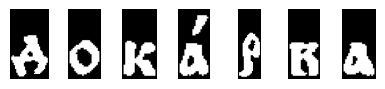

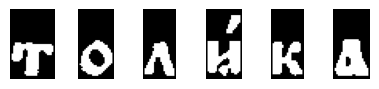

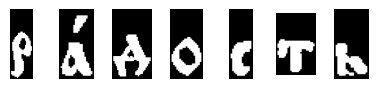

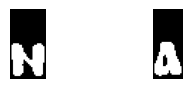

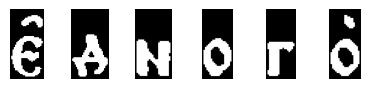

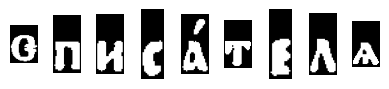

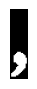

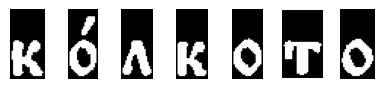

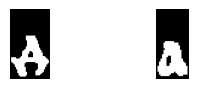

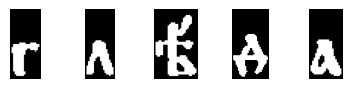

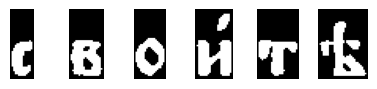

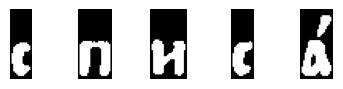

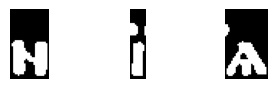

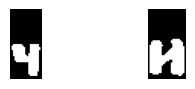

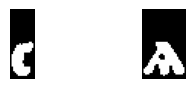

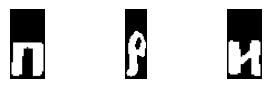

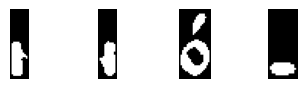

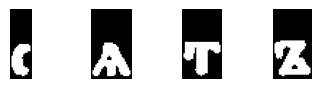

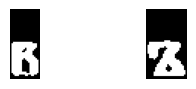

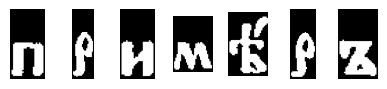

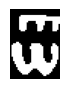

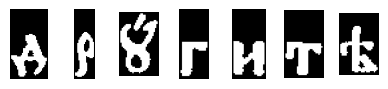

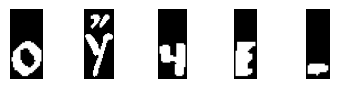

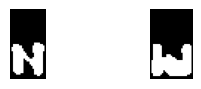

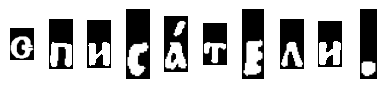

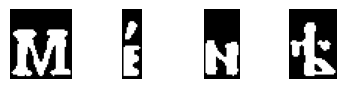

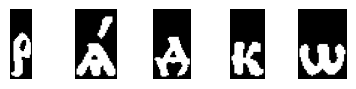

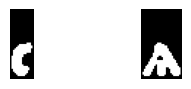

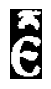

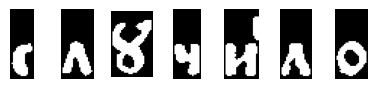

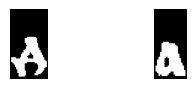

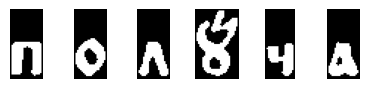

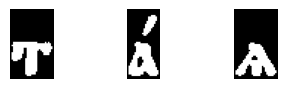

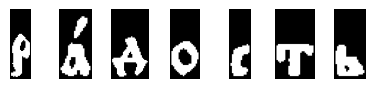

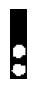

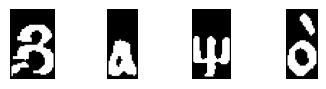

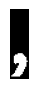

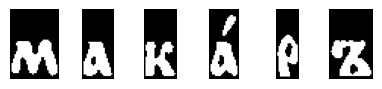

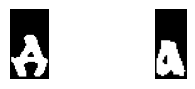

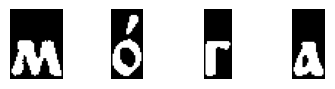

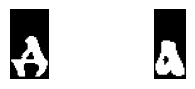

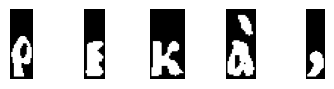

In [16]:
array_lines = []
for i in range(len(line_images)):
    array_words = []
    words = word_segmentation(line_images[i])
    for j in range(len(words)):
        array_letters = []
        letters = letter_segmentation(words[j])
        for k in range(len(letters)):
            array_letters.append(letters[k])
        array_words.append(letters)
    array_lines.append(array_words)

### Letter recognition

In [17]:
def find_height_of_letter(letter):
    thresh_letter = thresholding(letter, False)
    first_nonzero_row = np.where((thresh_letter == 255).any(axis=1))[0][0]
    return thresh_letter.shape[0] - first_nonzero_row

def cut_double_letters(array_lines):
    
    total_height = sum(find_height_of_letter(letter) for line in array_lines for word in line for letter in word)
    total_length = sum(letter.shape[1] for line in array_lines for word in line for letter in word)
    total_count = sum(len(word) for line in array_lines for word in line)

    avg_len = total_length / total_count
    avg_height = total_height / total_count

    new_array = []
    for line in array_lines:
        array_words = []
        for word in line:
            array_letters = []
            for letter in word:
                height = find_height_of_letter(letter)
                width = letter.shape[1]

                if width > avg_len * 2 and height < avg_height:
                    amt = round(width / avg_len)
                    split_width = width / amt
                    array_letters.append([letter[:, int(s*split_width):int((s+1)*split_width)] for s in range(amt)])
                else:
                    array_letters.append(letter)

            array_words.append(array_letters)
        new_array.append(array_words)

    return new_array

This function finds a letter and its accent in an image.

In [18]:
def find_parts_of_letters(sorted_contours, letter):
    
    def cropp_letter(letter, a, b, c, d):
        a_index = a - 1 if a != 0 else a
        c_index = c - 1 if c != 0 else c
        return letter[a_index:b+1, c_index:d+1]
    
    parts_of_letters = []
    x1, y1, w1, h1 = cv2.boundingRect(sorted_contours[0])
    if len(sorted_contours) == 1:
        cut_letter = letter[y1-1:, :] if y1 != 0 else letter
        parts_of_letters.append(cut_letter)
    else:
        x2, y2, w2, h2 = cv2.boundingRect(sorted_contours[1])
        if len(sorted_contours) == 2:
            if y2 >= y1+h1 and y1+h1 < letter.shape[0]//2:
                if (x1 <= letter.shape[1] // 2 - 2 <= x1+w1) or (x1 <= letter.shape[1] // 2 + 2 <= x1+w1):
                    cut_letter1 = letter[y2-1:, :]
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.extend([cut_letter1, cut_letter2])
                else:
                    cut_letter = letter[y2-1:, :]
                    parts_of_letters.append(cut_letter)
            else:
                y = min_sorted_contours(sorted_contours)
                cut_letter = letter[y-1:, :]
                parts_of_letters.append(cut_letter)
        else:
            x3, y3, w3, h3 = cv2.boundingRect(sorted_contours[2])
            if y3 >= y1+h1 and y1+h1 < letter.shape[0]//2 and y3 > y2+h2 and y2+h2 < letter.shape[0]//2:
                mid_line = letter.shape[1] // 2
                if ((x1 <= mid_line - 2 <= x1+w1) or (x1 <= mid_line + 2 <= x1+w1)) and \
                not ((x2 <= mid_line - 2 <= x2+w2) or (x2 <= mid_line + 2 <= x2+w2)):
                    cut_letter1 = letter[y3-1:, :]
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.extend([cut_letter1, cut_letter2])
                elif ((x2 <= mid_line - 2 <= x2+w2) or (x2 <= mid_line + 2 <= x2+w2)) and \
                not ((x1 <= mid_line - 2 <= x1+w1) or (x1 <= mid_line + 2 <= x1+w1)):
                    cut_letter1 = letter[y3-1:, :]
                    cut_letter2 = cropp_letter(letter, y2, y2+h2, x2, x2+w2)
                    parts_of_letters.extend([cut_letter1, cut_letter2])
                else:
                    cut_letter1 = letter[y3-1:, :]
                    cut_letter2 = cropp_letter(letter, min(y1, y2), max(y1+h1, y2+h2), min(x1, x2), max(x1+w1, x2+w2))
                    parts_of_letters.extend([cut_letter1, cut_letter2])
            else:
                y = min_sorted_contours(sorted_contours[1:])
                if y >= y1+h1 and y1+h1 < letter.shape[0]//2:
                    cut_letter1 = letter[y-1:, :]
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.extend([cut_letter1, cut_letter2])
                else:
                    y = min_sorted_contours(sorted_contours)
                    cut_letter = letter[y-1:, :]
                    parts_of_letters.append(cut_letter)
    return parts_of_letters

This function recognizes letters and superscripts separately using two trained CNN. Images with letters are reduced to size (28, 28), images with superscripts are reduced to size (16, 16).

In [19]:
def recognize_characters_from_images(array_lines):
    
    def resize_image(letter, size=(28, 28)):
        h, w = letter.shape
        if h != w:
            padding = abs(h-w) // 2
            if w > h:
                letter = np.pad(letter, ((padding, padding + (h-w)%2), (0, 0)), mode='constant')
            else:
                letter = np.pad(letter, ((0, 0), (padding, padding + (w-h)%2)), mode='constant')
        return cv2.resize(letter.astype(float), size)
    
    def remove_small_contours(sorted_contours):
        new_contours = [ctr for ctr in sorted_contours if cv2.boundingRect(ctr)[2] * cv2.boundingRect(ctr)[3] > 3]
        return new_contours
    
    text = []
    new_array_lines = cut_double_letters(array_lines)
    
    kernel = np.ones((1, 5), np.uint8)
    
    for i in range(len(new_array_lines)):
        for j in range(len(new_array_lines[i])):
            for k in range(len(new_array_lines[i][j])):
        
                letter = new_array_lines[i][j][k]
                height = find_height_of_letter(letter)
                
                if letter.shape[0] > height:
                    letter = letter[-height:, :]
                    
                dilated = cv2.dilate(letter, kernel, iterations = 1)    
                sorted_contours = find_contours(dilated, 1)
                sorted_contours = remove_small_contours(sorted_contours)
                
                if len(sorted_contours):
                    parts_of_letters = find_parts_of_letters(sorted_contours, letter)
                    parts_of_letters[0] = resize_image(parts_of_letters[0])
                    cut_letter_array = tf.keras.utils.img_to_array(parts_of_letters[0]) / 255.0
                    y_pred = model_loaded.predict(cut_letter_array)
                    y_pred_bool = (y_pred > 0.5)
                    
                    if not (np.all(y_pred_bool == False)):
                        text.append(str(CHURCH_SLAVONIC_LETTERS[np.argmax(y_pred)]))

                    if len(parts_of_letters) >= 2:
                        
                        parts_of_letters[1] = resize_image(parts_of_letters[1], (16, 16))
                        cut_sign_array = tf.keras.utils.img_to_array(parts_of_letters[1]) / 255.0
                        y_pred = model_loaded_diac.predict(cut_sign_array, verbose=0)
                        y_pred_bool = (y_pred > 0.5)
                        
                        if not (np.all(y_pred_bool == False)):
                            
                            argmax_y_pred = np.argmax(y_pred)
                            diacritic = str(CHURCH_SLAVONIC_DIACRITICS[argmax_y_pred])
                            last_char = text[-1]

                            special_cases = {
                                5: ("\u0461", diacritic),
                                8: (LETTERS_WITH_TITLE, diacritic),
                                3: ("\u0461", diacritic),
                                6: ("\u0131", diacritic),
                                9: ("\u002E", ':'),
                                9: ("\u002C", ';')
                            }
                            
                            if argmax_y_pred in special_cases:
                                if last_char in special_cases[argmax_y_pred][0] or last_char == special_cases[argmax_y_pred][0]:
                                    text.pop()
                                    text.append(special_cases[argmax_y_pred][1])
                                    continue
                            
                            if last_char in CHURCH_SLAVONIC_VOWELS and argmax_y_pred not in [5, 6, 8, 9]:
                                text.append(diacritic)

            text.append(" ")
        text.append("\n")
    return text

Removal of some recognition errors: split letters, space before colon and newline translation.

In [20]:
def remove_errors_from_text(text):
    text_with_corrections = [text[0], text[1]]
    cut_letter_sets = [["\u044C", "\u0131", "\u044B"], ["\u0131", "\u0131", "\u043D"], ["\u002C", "\u0131", "\u0447"],
            ["\u0446", "\u0131", "\u0449"]]
    
    def connect_cut_letters(text_with_corrections, letter, next_letter=True):
        text_with_corrections.pop()
        if next_letter:
            text_with_corrections.pop()
        text_with_corrections.append(letter)
    
    for i in range(2, len(text)):
        
        if text[i] not in CHURCH_SLAVONIC_DIACRITICS:
            for cls in cut_letter_sets:
                if text[i-2] == cls[0] and text[i-1] == cls[1]:
                    connect_cut_letters(text_with_corrections, cls[2])
        
        flag = False
        if i == len(text)-1:
            for cls in cut_letter_sets:
                if text[i-1] == cls[0] and text[i] == cls[1]:
                    connect_cut_letters(text_with_corrections, cls[2], False)
                    flag = True
            if flag:
                continue
            
        if text[i-1] == "\u0131" and text[i] == "\u0440":
            text_with_corrections.pop()
            text_with_corrections.append("\u0449")
            continue
            
        if text[i-1] == " " and text[i] in [",", ":", "\n"]:
            text_with_corrections.pop()
        text_with_corrections.append(text[i])
    return text_with_corrections

Loading trained models.

In [21]:
model_loaded = keras.models.load_model('model_letters')
model_loaded_diac = keras.models.load_model('model_diac')

In [22]:
text_from_image = recognize_characters_from_images(array_lines)
text_from_image = remove_errors_from_text(text_from_image)

file = open("page.txt", "w", encoding = 'utf-8')
for char in text_from_image:
    file.write(char)
file.close()

1/1 [==============================] - 0s 32ms/step


In [23]:
for symbol in text_from_image:
    print(symbol, end = '')

дрꙋ́го не дока́рва толи́ка ра́дость
на е҆дного̀ списа́телѧ, ко́лкото да
глѣ́да свои́тѣ списа́ н̈ѧ чи сѧ при но́–
сѧтъ въ примѣ́ръ ѿ дрꙋ́гитѣ оу҆́чет
ны списа́тели. ме́нѣ рѧ́дкѡ сѧ е҆̀
слꙋчило да полꙋ́ча та́ѧ ра́дость .
ащо̀, мака́ръ да мо́га да река̀,


Image text saved to file ```page.txt```. For the correct display of characters you need to download Church Slavonic font in Unicode ([for example from this site](https://sci.ponomar.net/fonts.html)). 
The text will look like this with a special font: 


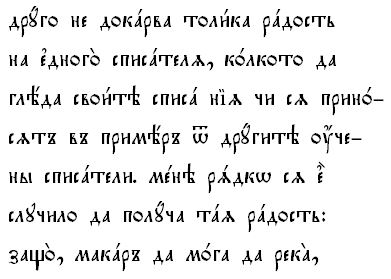